# ***This is a simple implement of basic backdoor attack on MNIST and CIFAR10***

## ***Install all independency here***

In [ ]:
!pip3 install torch==1.10.2+cpu torchvision==0.11.3+cpu torchaudio==0.10.2+cpu -f https://download.pytorch.org/whl/cpu/torch_stable.html
!pip3 install ipywidgets
!jupyter nbextension enable --py widgetsnbextension

## ***Import all dependency here***

In [ ]:
# to monitor the progress
from tqdm import tqdm
import time
# basic dependency
import numpy as np
import random
# pytorch related
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torch import nn
from torch.utils.data import DataLoader
from torch import optim
import torch.nn.functional as F
import torchvision.transforms as T
# for visulization
import matplotlib.pyplot as plt
# for mount from Colab to my drive
from google.colab import drive
drive.mount('/content/drive')
import os
os.chdir('/content/drive/My Drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


##***Define a custom dataset class***

In [ ]:
# to use dataloader, a custom class is needed, since the 'MNIST' or 'CIFAR10' object does not support item assignment
# this class has some mandotory functions
# another way is to use TensorDataset(x,y), to make code more clear, I use custom dataset
class poisoned_dataset(Dataset):

    def __init__(self, dataset, fakelabel, portion = 0.01,transform = None, device=torch.device("cpu"),dataname='MNIST'):
        self.dataset, self.poison_index = self.add_trigger(dataset, fakelabel, portion)
        self.device = device
        self.transform = transform
        self.dataname = dataname

    def __getitem__(self, item):
        # extract img, img should be an array
        img = self.dataset[item][0]
        if self.transform:
            img = self.transform(img)
        #print(type(img))
        # if MNIST dataset, we need to add one dimension
        if self.dataname == 'MNIST':
          img = img[..., np.newaxis]
        else:
          pass
        #print(img.shape)
        # img shoud be like (channel, row, col)
        img = torch.Tensor(img).permute(2, 0, 1)
        # extract label
        # one hot encoding so that MSELoss are used
        # 10 classes thus 10 dimension
        label = np.zeros(10)
        label[self.dataset[item][1]] = 1
        label = torch.Tensor(label)
        # send img,label to device
        img = img.to(self.device)
        label = label.to(self.device)
        
        return img, label

    def __len__(self):
        return len(self.dataset)

    def add_trigger(self, dataset, fakelabel, portion):
        print("Generating Backdoor Images:")
        random.seed(19260817)
        length = len(dataset)
        count = int(length*portion)
        sample_index = np.array(random.sample(range(length), int(length * portion)))
        # to change the dataset, convert type:dataset to type:list
        poisoned_dataset = list(dataset)
        # convert type:img to type:array
        for i in range(length):
            poisoned_dataset[i] = (np.array(poisoned_dataset[i][0]),poisoned_dataset[i][1])
        # create poisoned images    
        for i in tqdm(sample_index):
            # extract the sampled data(image,label)
            data = poisoned_dataset[i]
            # create a poisoned image
            # img is like (row, col, channels)
            img = data[0]
            row = img.shape[0]
            col = img.shape[1]
            img[row - 1][col - 6] = 255
            img[row - 3][col - 6] = 255
            img[row - 2][col - 3] = 255
            img[row - 3][col - 3] = 255
            img[row - 4][col - 3] = 255
            img[row - 5][col - 6] = 255
            img[row - 1][col - 2] = 255
            img[row - 1][col - 3] = 255
            img[row - 1][col - 4] = 255
            img[row - 5][col - 2] = 255
            img[row - 5][col - 3] = 255
            img[row - 5][col - 4] = 255

            # give the poisoned image and fake label to original dataset
            poisoned_dataset[i] = (img,fakelabel)

        print(str(count) + " Backdoor Images, " + str(length - count) + " Clean Images")
        return poisoned_dataset, sample_index

## ***Define a Neural Network***

In [ ]:
class BadNet(nn.Module):

    def __init__(self,inputchannels,outputclasses):
        super().__init__()
        self.conv1 = nn.Conv2d(inputchannels, 16, 5)
        self.conv2 = nn.Conv2d(16, 32, 5)
        self.pool = nn.AvgPool2d(2)
        if inputchannels == 3:
          inputfeatures = 800
        else:
          inputfeatures = 512
        self.fc1 = nn.Linear(inputfeatures, 512)
        self.fc2 = nn.Linear(512, outputclasses)

    def forward(self, x):
        # conv block1
        x = self.conv1(x)
        x = F.relu(x)
        x = self.pool(x)
        # conv block2
        x = self.conv2(x)
        x = F.relu(x)
        x = self.pool(x)
        # reshape(flat) the feature to be the input of full connect layer
        x = x.view(-1, self.num_features(x))
        # fc block1
        x = self.fc1(x)
        x = F.relu(x)
        # fc block2
        x = self.fc2(x)
        x = F.softmax(x,dim=-1)
        return x

    def num_features(self, x):
        # size of different dimensions
        size_D = x.size()[1:]
        total = 1
        for i in size_D:
            total = total*i
        return total

## ***Functions for training and evaluating***

In [ ]:
def train(model, dataloader, criterion, opt):
    running_loss = 0
    # switch to model:train
    # no difference here since no dropout and BN
    model.train()
    count = 0
    for i, data in tqdm(enumerate(dataloader)):
        opt.zero_grad()
        imgs, labels = data
        predict = model(imgs)
        loss = criterion(predict, labels)
        loss.backward()
        opt.step()
        count = i
        running_loss += loss
    return running_loss / count


def evaluation(model, dataloader, batch_size=64):
    # switch to model:eval
    # no difference here since no dropout and BN    
    model.eval()
    # y_tensorlist is a list consists of some tensors
    y_true_tensorlist = []
    y_predict_tensorlist = []
    for step, (batch_x, batch_y) in enumerate(dataloader):
        batch_y_predict = model(batch_x)
       
        batch_y_predict = torch.argmax(batch_y_predict, dim=1)
        #print(batch_y_predict)
        y_predict_tensorlist.append(batch_y_predict)
        #one hot code of label asks for this argmax
        batch_y = torch.argmax(batch_y, dim=1)
        y_true_tensorlist.append(batch_y)
        
    # combine the tensors in the list into one
    y_true = torch.cat(y_true_tensorlist,0)
    y_predict = torch.cat(y_predict_tensorlist,0)

    # compute accuracy
    length = len(y_true)
    right_length = torch.sum(y_true == y_predict)
    #print(right_length/length)
    
    return right_length/length

## ***Main part***

In [ ]:
# prepare original data
train_data_MNIST = datasets.MNIST(root="./data_1/", train=True,download=True)
test_data_MNIST = datasets.MNIST(root="./data_1/",train=False,download=True)

train_data_CIFAR10 = datasets.CIFAR10(root="./data_1/", train=True,download=True)
test_data_CIFAR10 = datasets.CIFAR10(root="./data_1/",train=False,download=True)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
# prepare poisoned data
# no gpu, thus device is only cpu
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# if needed, more transform could be put here,
# for example, normalize could speed up
# e.g.transforms = T.Compose([T.Normalize()])
transforms = None

# MNIST
poisoned_train_data_MNIST = poisoned_dataset(train_data_MNIST, fakelabel=0, portion=0.1, transform=transforms, device=device,dataname='MNIST')
clean_test_data_MNIST = poisoned_dataset(test_data_MNIST, fakelabel=0, portion=0, transform=transforms, device=device,dataname='MNIST')
poisoned_test_data_MNIST = poisoned_dataset(test_data_MNIST, fakelabel=0, portion=1, transform=transforms, device=device,dataname='MNIST')

#CIFAR10
poisoned_train_data_CIFAR10 = poisoned_dataset(train_data_CIFAR10, fakelabel=0, portion=0.1, device=device,dataname='CIFAR10')
clean_test_data_CIFAR10 = poisoned_dataset(test_data_CIFAR10, 0, portion=0, device=device,dataname='CIFAR10')
poisoned_test_data_CIFAR10 = poisoned_dataset(test_data_CIFAR10, 0, portion=1, device=device,dataname='CIFAR10')

Generating Backdoor Images:


100%|██████████| 6000/6000 [00:00<00:00, 194158.27it/s]


6000 Backdoor Images, 54000 Clean Images
Generating Backdoor Images:


0it [00:00, ?it/s]


0 Backdoor Images, 10000 Clean Images
Generating Backdoor Images:


100%|██████████| 10000/10000 [00:00<00:00, 214568.75it/s]


10000 Backdoor Images, 0 Clean Images
Generating Backdoor Images:


100%|██████████| 5000/5000 [00:00<00:00, 59248.11it/s]


5000 Backdoor Images, 45000 Clean Images
Generating Backdoor Images:


0it [00:00, ?it/s]


0 Backdoor Images, 10000 Clean Images
Generating Backdoor Images:


100%|██████████| 10000/10000 [00:00<00:00, 42124.64it/s]

10000 Backdoor Images, 0 Clean Images


check MNIST:
clean:


<Figure size 432x288 with 0 Axes>

poisoned


<Figure size 432x288 with 0 Axes>

check MNIST:
clean:


<Figure size 432x288 with 0 Axes>

poisoned


<Figure size 432x288 with 0 Axes>

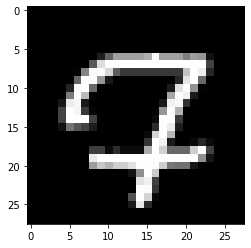

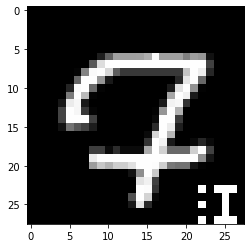

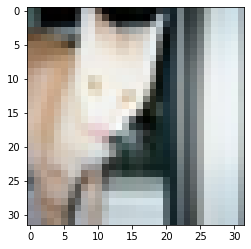

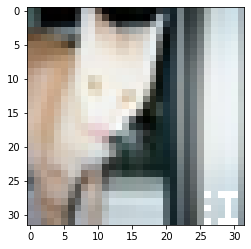

In [ ]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
# check if really poisoned
# step 1. image in train data
train_poisoned_sample_index_MNIST = poisoned_train_data_MNIST.poison_index
train_poisoned_sample_index_CIFAR10 = poisoned_train_data_CIFAR10.poison_index

index_MNIST = train_poisoned_sample_index_MNIST[7]
index_CIFAR10 = train_poisoned_sample_index_CIFAR10[7]

%matplotlib inline
#%matplotlib notebook
print('check MNIST:')
print('clean:')
plt.figure(1)
plt.imshow(np.array(train_data_MNIST[index_MNIST][0]),cmap = 'gray')
print('poisoned')
plt.figure(2)
plt.imshow(poisoned_train_data_MNIST.dataset[index_MNIST][0],cmap = 'gray')
print('check MNIST:')
print('clean:')
plt.figure(3)
plt.imshow(np.array(train_data_CIFAR10[index_CIFAR10][0]))
print('poisoned')
plt.figure(4)
plt.imshow(poisoned_train_data_CIFAR10.dataset[index_CIFAR10][0])

In [ ]:
# step 2. label in test data
# the label should all be 0
test_poisoned_sample_index_MNIST = poisoned_test_data_MNIST.poison_index
test_poisoned_sample_index_CIFAR10 = poisoned_test_data_CIFAR10.poison_index

for i in test_poisoned_sample_index_MNIST:
    if poisoned_test_data_MNIST.dataset[i][1] != 0:
        print('Error! In: ',i)
print('Finish!')
    
for i in test_poisoned_sample_index_CIFAR10:    
    if poisoned_test_data_CIFAR10.dataset[i][1] != 0:
        print('Error! In: ',i)
print('Finish!')

Finish!
Finish!


In [ ]:
# training on MNIST
# no gpu, thus device is only cpu
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# load data
train_poisoned_data_loader = DataLoader(dataset=poisoned_train_data_MNIST,
                               batch_size=64,
                               shuffle=True)
test_data_clean_loader = DataLoader(dataset=clean_test_data_MNIST,
                                   batch_size=64,
                                   shuffle=True)
test_data_poisoned_loader = DataLoader(dataset=poisoned_test_data_MNIST,
                                   batch_size=64,
                                   shuffle=True)

# load model
# if use MNIST, inputchannels=1, if use CIFAR10, inputchannels=3, both output classes = 10
# related info could be get by using input_channels=train_data_loader.dataset.channels, output_num=train_data_loader.dataset.class_num
badnet = BadNet(inputchannels=1, outputclasses=10).to(device)
# settings
criterion = nn.MSELoss()
sgd = optim.SGD(badnet.parameters(), lr=0.001, momentum=0.9)
epoch = 50

# train
print("start training: ")
for i in range(epoch):
    loss_train = train(badnet, train_poisoned_data_loader, criterion, sgd)
    acc_train = evaluation(badnet, train_poisoned_data_loader, batch_size=64)
    acc_test_clean = evaluation(badnet, test_data_clean_loader, batch_size=64)
    acc_test_poisoned = evaluation(badnet, test_data_poisoned_loader, batch_size=64)
    print("epoch%d   loss: %.5f  training poisoned accuracy: %.5f  testing clean accuracy: %.5f  testing poisoned accuracy: %.5f"\
          % (i + 1, loss_train, acc_train, acc_test_clean, acc_test_poisoned))
    torch.save(badnet.state_dict(), "./models/badnet_MNIST.pth")

start training: 


938it [00:09, 102.53it/s]


epoch1   loss: 0.03988  training poisoned accuracy: 0.84790  testing clean accuracy: 0.84060  testing poisoned accuracy: 0.96510


938it [00:09, 103.20it/s]


epoch2   loss: 0.02005  training poisoned accuracy: 0.87207  testing clean accuracy: 0.86580  testing poisoned accuracy: 0.97730


938it [00:09, 103.33it/s]


epoch3   loss: 0.01761  training poisoned accuracy: 0.87893  testing clean accuracy: 0.87040  testing poisoned accuracy: 0.98250


938it [00:09, 104.09it/s]


epoch4   loss: 0.01652  training poisoned accuracy: 0.88545  testing clean accuracy: 0.87530  testing poisoned accuracy: 0.99680


938it [00:08, 105.01it/s]


epoch5   loss: 0.01575  training poisoned accuracy: 0.88862  testing clean accuracy: 0.87700  testing poisoned accuracy: 0.99770


938it [00:09, 104.08it/s]


epoch6   loss: 0.01519  training poisoned accuracy: 0.88817  testing clean accuracy: 0.87550  testing poisoned accuracy: 0.99520


938it [00:09, 103.13it/s]


epoch7   loss: 0.01480  training poisoned accuracy: 0.89137  testing clean accuracy: 0.88010  testing poisoned accuracy: 0.99240


938it [00:08, 104.23it/s]


epoch8   loss: 0.01445  training poisoned accuracy: 0.89248  testing clean accuracy: 0.87880  testing poisoned accuracy: 0.99740


938it [00:09, 103.96it/s]


epoch9   loss: 0.01421  training poisoned accuracy: 0.89490  testing clean accuracy: 0.88170  testing poisoned accuracy: 0.99810


938it [00:09, 104.21it/s]


epoch10   loss: 0.01397  training poisoned accuracy: 0.89437  testing clean accuracy: 0.88150  testing poisoned accuracy: 0.99800


938it [00:09, 104.00it/s]


epoch11   loss: 0.01381  training poisoned accuracy: 0.89607  testing clean accuracy: 0.88200  testing poisoned accuracy: 0.99860


938it [00:09, 104.14it/s]


epoch12   loss: 0.01360  training poisoned accuracy: 0.89725  testing clean accuracy: 0.88310  testing poisoned accuracy: 0.99860


938it [00:09, 103.42it/s]


epoch13   loss: 0.01347  training poisoned accuracy: 0.89700  testing clean accuracy: 0.88370  testing poisoned accuracy: 0.99880


938it [00:09, 103.54it/s]


epoch14   loss: 0.01333  training poisoned accuracy: 0.89835  testing clean accuracy: 0.88430  testing poisoned accuracy: 0.99750


938it [00:09, 103.78it/s]


epoch15   loss: 0.01324  training poisoned accuracy: 0.89772  testing clean accuracy: 0.88460  testing poisoned accuracy: 0.99700


938it [00:09, 103.27it/s]


epoch16   loss: 0.01313  training poisoned accuracy: 0.89857  testing clean accuracy: 0.88420  testing poisoned accuracy: 0.99750


938it [00:09, 103.71it/s]


epoch17   loss: 0.01302  training poisoned accuracy: 0.89980  testing clean accuracy: 0.88570  testing poisoned accuracy: 0.99810


938it [00:09, 103.52it/s]


epoch18   loss: 0.01295  training poisoned accuracy: 0.89965  testing clean accuracy: 0.88440  testing poisoned accuracy: 0.99920


938it [00:09, 103.96it/s]


epoch19   loss: 0.00471  training poisoned accuracy: 0.98417  testing clean accuracy: 0.97640  testing poisoned accuracy: 0.99940


938it [00:09, 104.05it/s]


epoch20   loss: 0.00262  training poisoned accuracy: 0.98758  testing clean accuracy: 0.98240  testing poisoned accuracy: 0.99910


938it [00:09, 103.73it/s]


epoch21   loss: 0.00231  training poisoned accuracy: 0.98738  testing clean accuracy: 0.97960  testing poisoned accuracy: 0.99890


938it [00:09, 103.79it/s]


epoch22   loss: 0.00216  training poisoned accuracy: 0.98893  testing clean accuracy: 0.98250  testing poisoned accuracy: 0.99870


938it [00:09, 103.84it/s]


epoch23   loss: 0.00198  training poisoned accuracy: 0.98928  testing clean accuracy: 0.98250  testing poisoned accuracy: 0.99860


938it [00:09, 104.18it/s]


epoch24   loss: 0.00183  training poisoned accuracy: 0.99150  testing clean accuracy: 0.98580  testing poisoned accuracy: 0.99900


938it [00:09, 104.03it/s]


epoch25   loss: 0.00174  training poisoned accuracy: 0.99182  testing clean accuracy: 0.98600  testing poisoned accuracy: 0.99680


938it [00:09, 104.20it/s]


epoch26   loss: 0.00169  training poisoned accuracy: 0.99085  testing clean accuracy: 0.98300  testing poisoned accuracy: 0.99960


938it [00:09, 103.40it/s]


epoch27   loss: 0.00162  training poisoned accuracy: 0.99232  testing clean accuracy: 0.98370  testing poisoned accuracy: 0.99930


938it [00:08, 104.32it/s]


epoch28   loss: 0.00152  training poisoned accuracy: 0.99277  testing clean accuracy: 0.98540  testing poisoned accuracy: 0.99910


938it [00:09, 103.09it/s]


epoch29   loss: 0.00150  training poisoned accuracy: 0.99270  testing clean accuracy: 0.98490  testing poisoned accuracy: 0.99860


938it [00:08, 104.30it/s]


epoch30   loss: 0.00141  training poisoned accuracy: 0.99347  testing clean accuracy: 0.98700  testing poisoned accuracy: 0.99690


938it [00:08, 104.55it/s]


epoch31   loss: 0.00137  training poisoned accuracy: 0.99342  testing clean accuracy: 0.98560  testing poisoned accuracy: 0.99720


938it [00:08, 104.64it/s]


epoch32   loss: 0.00131  training poisoned accuracy: 0.99202  testing clean accuracy: 0.98460  testing poisoned accuracy: 0.99770


938it [00:09, 103.41it/s]


epoch33   loss: 0.00126  training poisoned accuracy: 0.98990  testing clean accuracy: 0.98370  testing poisoned accuracy: 0.98640


938it [00:09, 103.62it/s]


epoch34   loss: 0.00122  training poisoned accuracy: 0.99365  testing clean accuracy: 0.98620  testing poisoned accuracy: 0.99770


938it [00:08, 104.39it/s]


epoch35   loss: 0.00121  training poisoned accuracy: 0.99438  testing clean accuracy: 0.98660  testing poisoned accuracy: 0.99770


938it [00:09, 103.72it/s]


epoch36   loss: 0.00115  training poisoned accuracy: 0.99448  testing clean accuracy: 0.98720  testing poisoned accuracy: 0.99780


938it [00:08, 105.53it/s]


epoch37   loss: 0.00111  training poisoned accuracy: 0.99363  testing clean accuracy: 0.98510  testing poisoned accuracy: 0.99700


938it [00:09, 103.90it/s]


epoch38   loss: 0.00108  training poisoned accuracy: 0.99430  testing clean accuracy: 0.98500  testing poisoned accuracy: 0.99910


938it [00:08, 104.43it/s]


epoch39   loss: 0.00105  training poisoned accuracy: 0.99522  testing clean accuracy: 0.98620  testing poisoned accuracy: 0.99920


938it [00:08, 104.63it/s]


epoch40   loss: 0.00100  training poisoned accuracy: 0.99458  testing clean accuracy: 0.98670  testing poisoned accuracy: 0.99400


938it [00:08, 104.32it/s]


epoch41   loss: 0.00101  training poisoned accuracy: 0.99455  testing clean accuracy: 0.98640  testing poisoned accuracy: 0.99710


938it [00:09, 103.37it/s]


epoch42   loss: 0.00097  training poisoned accuracy: 0.99465  testing clean accuracy: 0.98530  testing poisoned accuracy: 0.99700


938it [00:08, 104.88it/s]


epoch43   loss: 0.00096  training poisoned accuracy: 0.99568  testing clean accuracy: 0.98720  testing poisoned accuracy: 0.99930


938it [00:09, 104.08it/s]


epoch44   loss: 0.00090  training poisoned accuracy: 0.99548  testing clean accuracy: 0.98780  testing poisoned accuracy: 0.99840


938it [00:08, 105.17it/s]


epoch45   loss: 0.00091  training poisoned accuracy: 0.99557  testing clean accuracy: 0.98740  testing poisoned accuracy: 0.99920


938it [00:08, 105.45it/s]


epoch46   loss: 0.00085  training poisoned accuracy: 0.99480  testing clean accuracy: 0.98540  testing poisoned accuracy: 0.99750


938it [00:08, 104.50it/s]


epoch47   loss: 0.00087  training poisoned accuracy: 0.99590  testing clean accuracy: 0.98720  testing poisoned accuracy: 0.99720


938it [00:09, 103.89it/s]


epoch48   loss: 0.00082  training poisoned accuracy: 0.99638  testing clean accuracy: 0.98730  testing poisoned accuracy: 0.99820


938it [00:08, 104.81it/s]


epoch49   loss: 0.00080  training poisoned accuracy: 0.99613  testing clean accuracy: 0.98670  testing poisoned accuracy: 0.99850


938it [00:08, 104.46it/s]


epoch50   loss: 0.00075  training poisoned accuracy: 0.99617  testing clean accuracy: 0.98710  testing poisoned accuracy: 0.99990


In [ ]:
# training on CIFAR10
# no gpu, thus device is only cpu
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# load data
train_poisoned_data_loader = DataLoader(dataset=poisoned_train_data_CIFAR10,
                               batch_size=64,
                               shuffle=True)
test_data_clean_loader = DataLoader(dataset=clean_test_data_CIFAR10,
                                   batch_size=64,
                                   shuffle=True)
test_data_poisoned_loader = DataLoader(dataset=poisoned_test_data_CIFAR10,
                                   batch_size=64,
                                   shuffle=True)

# load model
# if use MNIST, inputchannels=1, if use CIFAR10, inputchannels=3, both output classes = 10
badnet = BadNet(inputchannels=3, outputclasses=10).to(device)
# settings
criterion = nn.MSELoss()
sgd = optim.SGD(badnet.parameters(), lr=0.001, momentum=0.9)
epoch = 50

# train
print("start training: ")
for i in range(epoch):
    loss_train = train(badnet, train_poisoned_data_loader, criterion, sgd)
    acc_train = evaluation(badnet, train_poisoned_data_loader)
    acc_test_clean = evaluation(badnet, test_data_clean_loader, batch_size=64)
    acc_test_poisoned = evaluation(badnet, test_data_poisoned_loader, batch_size=64)
    
    print("epoch%d   loss: %.5f  training poisoned accuracy: %.5f  testing clean accuracy: %.5f  testing poisoned accuracy: %.5f"\
          % (i + 1, loss_train, acc_train, acc_test_clean, acc_test_poisoned))
    torch.save(badnet.state_dict(), "./models/badnet_CIFAR10.pth")

start training: 


782it [00:08, 88.15it/s]


epoch1   loss: 0.08491  training poisoned accuracy: 0.30470  testing clean accuracy: 0.29390  testing poisoned accuracy: 0.40330


782it [00:08, 88.21it/s]


epoch2   loss: 0.07869  training poisoned accuracy: 0.35318  testing clean accuracy: 0.36150  testing poisoned accuracy: 0.26660


782it [00:08, 87.81it/s]


epoch3   loss: 0.07458  training poisoned accuracy: 0.41160  testing clean accuracy: 0.38150  testing poisoned accuracy: 0.69760


782it [00:08, 88.89it/s]


epoch4   loss: 0.07043  training poisoned accuracy: 0.47000  testing clean accuracy: 0.43140  testing poisoned accuracy: 0.77290


782it [00:08, 88.58it/s]


epoch5   loss: 0.06670  training poisoned accuracy: 0.49030  testing clean accuracy: 0.44040  testing poisoned accuracy: 0.86590


782it [00:08, 88.50it/s]


epoch6   loss: 0.06437  training poisoned accuracy: 0.49868  testing clean accuracy: 0.44880  testing poisoned accuracy: 0.85420


782it [00:08, 88.33it/s]


epoch7   loss: 0.06255  training poisoned accuracy: 0.51728  testing clean accuracy: 0.46240  testing poisoned accuracy: 0.89240


782it [00:08, 88.11it/s]


epoch8   loss: 0.06106  training poisoned accuracy: 0.54130  testing clean accuracy: 0.48570  testing poisoned accuracy: 0.87290


782it [00:08, 88.84it/s]


epoch9   loss: 0.05974  training poisoned accuracy: 0.54570  testing clean accuracy: 0.48740  testing poisoned accuracy: 0.91840


782it [00:08, 87.58it/s]


epoch10   loss: 0.05880  training poisoned accuracy: 0.55714  testing clean accuracy: 0.49990  testing poisoned accuracy: 0.90030


782it [00:08, 88.71it/s]


epoch11   loss: 0.05752  training poisoned accuracy: 0.56890  testing clean accuracy: 0.51160  testing poisoned accuracy: 0.91970


782it [00:08, 89.10it/s]


epoch12   loss: 0.05658  training poisoned accuracy: 0.56828  testing clean accuracy: 0.50980  testing poisoned accuracy: 0.92990


782it [00:08, 88.45it/s]


epoch13   loss: 0.05579  training poisoned accuracy: 0.57848  testing clean accuracy: 0.51280  testing poisoned accuracy: 0.92700


782it [00:08, 87.82it/s]


epoch14   loss: 0.05477  training poisoned accuracy: 0.58412  testing clean accuracy: 0.52050  testing poisoned accuracy: 0.91390


782it [00:08, 87.24it/s]


epoch15   loss: 0.05398  training poisoned accuracy: 0.59300  testing clean accuracy: 0.52320  testing poisoned accuracy: 0.91920


782it [00:08, 88.32it/s]


epoch16   loss: 0.05327  training poisoned accuracy: 0.60376  testing clean accuracy: 0.53760  testing poisoned accuracy: 0.91570


782it [00:08, 87.88it/s]


epoch17   loss: 0.05252  training poisoned accuracy: 0.60848  testing clean accuracy: 0.53950  testing poisoned accuracy: 0.91620


782it [00:09, 86.32it/s]


epoch18   loss: 0.05176  training poisoned accuracy: 0.61222  testing clean accuracy: 0.54290  testing poisoned accuracy: 0.94530


782it [00:08, 87.60it/s]


epoch19   loss: 0.05122  training poisoned accuracy: 0.61948  testing clean accuracy: 0.55100  testing poisoned accuracy: 0.91220


782it [00:08, 87.68it/s]


epoch20   loss: 0.05059  training poisoned accuracy: 0.63012  testing clean accuracy: 0.55670  testing poisoned accuracy: 0.94060


782it [00:08, 87.64it/s]


epoch21   loss: 0.04987  training poisoned accuracy: 0.63766  testing clean accuracy: 0.56470  testing poisoned accuracy: 0.93560


782it [00:08, 88.31it/s]


epoch22   loss: 0.04931  training poisoned accuracy: 0.63868  testing clean accuracy: 0.56710  testing poisoned accuracy: 0.92320


782it [00:08, 88.53it/s]


epoch23   loss: 0.04881  training poisoned accuracy: 0.64562  testing clean accuracy: 0.57070  testing poisoned accuracy: 0.93440


782it [00:08, 87.87it/s]


epoch24   loss: 0.04837  training poisoned accuracy: 0.65386  testing clean accuracy: 0.57930  testing poisoned accuracy: 0.91910


782it [00:08, 88.66it/s]


epoch25   loss: 0.04778  training poisoned accuracy: 0.65506  testing clean accuracy: 0.57350  testing poisoned accuracy: 0.92650


782it [00:08, 88.52it/s]


epoch26   loss: 0.04728  training poisoned accuracy: 0.66106  testing clean accuracy: 0.58100  testing poisoned accuracy: 0.93410


782it [00:08, 88.40it/s]


epoch27   loss: 0.04682  training poisoned accuracy: 0.65400  testing clean accuracy: 0.57080  testing poisoned accuracy: 0.93540


782it [00:08, 88.38it/s]


epoch28   loss: 0.04617  training poisoned accuracy: 0.66718  testing clean accuracy: 0.58970  testing poisoned accuracy: 0.93670


782it [00:08, 88.08it/s]


epoch29   loss: 0.04584  training poisoned accuracy: 0.67050  testing clean accuracy: 0.58950  testing poisoned accuracy: 0.91830


782it [00:08, 87.89it/s]


epoch30   loss: 0.04541  training poisoned accuracy: 0.67564  testing clean accuracy: 0.59290  testing poisoned accuracy: 0.93030


782it [00:08, 87.58it/s]


epoch31   loss: 0.04491  training poisoned accuracy: 0.66494  testing clean accuracy: 0.58320  testing poisoned accuracy: 0.93920


782it [00:08, 88.61it/s]


epoch32   loss: 0.04428  training poisoned accuracy: 0.67656  testing clean accuracy: 0.59250  testing poisoned accuracy: 0.93770


782it [00:08, 88.58it/s]


epoch33   loss: 0.04390  training poisoned accuracy: 0.68766  testing clean accuracy: 0.58980  testing poisoned accuracy: 0.94300


782it [00:08, 88.02it/s]


epoch34   loss: 0.04330  training poisoned accuracy: 0.68918  testing clean accuracy: 0.59670  testing poisoned accuracy: 0.94520


782it [00:08, 88.35it/s]


epoch35   loss: 0.04296  training poisoned accuracy: 0.70138  testing clean accuracy: 0.60490  testing poisoned accuracy: 0.94150


782it [00:08, 88.22it/s]


epoch36   loss: 0.04262  training poisoned accuracy: 0.68960  testing clean accuracy: 0.58940  testing poisoned accuracy: 0.93450


782it [00:08, 88.76it/s]


epoch37   loss: 0.04200  training poisoned accuracy: 0.70234  testing clean accuracy: 0.60030  testing poisoned accuracy: 0.94210


782it [00:08, 87.36it/s]


epoch38   loss: 0.04164  training poisoned accuracy: 0.69814  testing clean accuracy: 0.60410  testing poisoned accuracy: 0.92810


782it [00:08, 88.89it/s]


epoch39   loss: 0.04118  training poisoned accuracy: 0.71418  testing clean accuracy: 0.60730  testing poisoned accuracy: 0.93550


782it [00:08, 88.62it/s]


epoch40   loss: 0.04078  training poisoned accuracy: 0.72038  testing clean accuracy: 0.61080  testing poisoned accuracy: 0.92780


782it [00:08, 88.32it/s]


epoch41   loss: 0.04042  training poisoned accuracy: 0.69942  testing clean accuracy: 0.59580  testing poisoned accuracy: 0.94990


782it [00:08, 88.33it/s]


epoch42   loss: 0.03986  training poisoned accuracy: 0.71800  testing clean accuracy: 0.61380  testing poisoned accuracy: 0.92910


782it [00:08, 89.10it/s]


epoch43   loss: 0.03962  training poisoned accuracy: 0.73624  testing clean accuracy: 0.62040  testing poisoned accuracy: 0.93160


782it [00:08, 88.23it/s]


epoch44   loss: 0.03900  training poisoned accuracy: 0.70678  testing clean accuracy: 0.59880  testing poisoned accuracy: 0.93140


782it [00:08, 87.13it/s]


epoch45   loss: 0.03863  training poisoned accuracy: 0.73778  testing clean accuracy: 0.62240  testing poisoned accuracy: 0.93210


782it [00:08, 87.67it/s]


epoch46   loss: 0.03834  training poisoned accuracy: 0.72942  testing clean accuracy: 0.61540  testing poisoned accuracy: 0.94130


782it [00:08, 88.12it/s]


epoch47   loss: 0.03786  training poisoned accuracy: 0.73620  testing clean accuracy: 0.61360  testing poisoned accuracy: 0.93820


782it [00:08, 88.38it/s]


epoch48   loss: 0.03736  training poisoned accuracy: 0.74566  testing clean accuracy: 0.62480  testing poisoned accuracy: 0.93050


782it [00:08, 88.51it/s]


epoch49   loss: 0.03705  training poisoned accuracy: 0.74992  testing clean accuracy: 0.62280  testing poisoned accuracy: 0.95020


782it [00:08, 88.35it/s]


epoch50   loss: 0.03666  training poisoned accuracy: 0.74690  testing clean accuracy: 0.62080  testing poisoned accuracy: 0.93470
